In [1]:
'''
ResNet 101 lesion

'''

'\nResNet 101 lesion\n\n'

# Imports

In [11]:
#To hide warnings export PYTHONWARNINGS="ignore"
#Imports{
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from keras import layers
from keras import models
import keras.utils as keras_utils
from keras.layers import Lambda

from  keras.applications import imagenet_utils
from  keras.applications.imagenet_utils import decode_predictions
from  keras_applications.imagenet_utils import _obtain_input_shape

import os
from os.path import dirname
from os.path import join
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' #Cha


import sys
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
if not sys.warnoptions:
    warnings.simplefilter("ignore")

    
import pickle
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from imageio import imread
from skimage.transform import resize
from scipy.io import loadmat

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans

import gc
import keras
import tensorflow as tf
from keras import backend as K
from keras_applications import imagenet_utils as utils
import PIL.Image
#}

# Model Definition

In [12]:
model_name = 'ResNet101'

In [13]:
#Code snippet needed to read activation values from each layer of the pre-trained artificial neural networks
def get_activations(model, layer, X_batch):
    #keras.backend.function(inputs, outputs, updates=None)
    get_activations = keras.backend.function([model.layers[0].input, keras.backend.learning_phase()], [model.layers[layer].output,])
    #The learning phase flag is a bool tensor (0 = test, 1 = train)
    activations = get_activations([X_batch,0])
    return activations

In [14]:
backend= keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils
keras.backend.image_data_format()

'channels_last'

In [15]:
#Resnet 101 models for Keras.

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np


backend= keras.backend
layers = keras.layers
models = keras.models
keras_utils = keras.utils


BASE_WEIGHTS_PATH = (
    'https://github.com/keras-team/keras-applications/'
    'releases/download/resnet/')
WEIGHTS_HASHES = {
    'resnet50': ('2cb95161c43110f7111970584f804107',
                 '4d473c1dd8becc155b73f8504c6f6626'),
    'resnet101': ('f1aeb4b969a6efcfb50fad2f0c20cfc5',
                  '88cf7a10940856eca736dc7b7e228a21'),
    'resnet152': ('100835be76be38e30d865e96f2aaae62',
                  'ee4c566cf9a93f14d82f913c2dc6dd0c'),
    'resnet50v2': ('3ef43a0b657b3be2300d5770ece849e0',
                   'fac2f116257151a9d068a22e544a4917'),
    'resnet101v2': ('6343647c601c52e1368623803854d971',
                    'c0ed64b8031c3730f411d2eb4eea35b5'),
    'resnet152v2': ('a49b44d1979771252814e80f8ec446f9',
                    'ed17cf2e0169df9d443503ef94b23b33'),
    'resnext50': ('67a5b30d522ed92f75a1f16eef299d1a',
                  '62527c363bdd9ec598bed41947b379fc'),
    'resnext101': ('34fb605428fcc7aa4d62f44404c11509',
                   '0f678c91647380debd923963594981b3')
}

def block1(x, filters, kernel_size=3, stride=1,
           conv_shortcut=True, name=None, lambda_mask = None, input_size = None):
    """A residual block.

    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        conv_shortcut: default True, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.

    # Returns
        Output tensor for the residual block.
    """
    global start_index, end_index, debug
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    #print(input_size, filters)
    if conv_shortcut is True:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride,name=name + '_0_conv')(x)
        #################
        if lambda_mask is not None:
            start_index = end_index
            end_index = start_index + (input_size* input_size* filters * 4)
            if debug:
                print(name + '_0_conv',start_index,end_index)
            shortcut_mask  = np.reshape(lambda_mask[start_index:end_index], (input_size, input_size, filters * 4))
        else:
            shortcut_mask = np.ones(shape=((input_size, input_size, filters * 4)))

        shortcut_mask  = backend.variable(shortcut_mask)
        shortcut = Lambda(lambda z: z * shortcut_mask)(shortcut)
        #################
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,
                                             name=name + '_0_bn')(shortcut)
        #################
        if lambda_mask is not None:
            start_index = end_index
            end_index = start_index + (input_size* input_size* filters * 4)
            if debug:
                print(name + '_0_bn',start_index,end_index)
            shortcut_mask  = np.reshape(lambda_mask[start_index:end_index], (input_size, input_size, filters * 4))
        else:
            shortcut_mask = np.ones(shape=((input_size, input_size, filters * 4)))

        shortcut_mask  = backend.variable(shortcut_mask)
        shortcut = Lambda(lambda z: z * shortcut_mask)(shortcut)
        #################
    else:
        shortcut = x
    

    x = layers.Conv2D(filters, 1, strides=stride, name=name + '_1_conv')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (input_size* input_size* (filters))
        if debug:
            print(name + '_1_conv',start_index,end_index)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (input_size, input_size, filters))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (input_size* input_size* (filters))
        if debug:
            print(name + '_1_bn',start_index,end_index)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (input_size, input_size, filters))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################

    x = layers.Conv2D(filters, kernel_size, padding='SAME',
                      name=name + '_2_conv')(x)
   #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (input_size* input_size* (filters))
        if debug:
            print(name + '_2_conv',start_index,end_index)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (input_size, input_size, filters))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (input_size* input_size* (filters))
        if debug:
            print(name + '_2_bn',start_index,end_index)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (input_size, input_size, filters))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (input_size* input_size* (filters) * 4)
        if debug:
            print(name + '_3_conv',start_index,end_index)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (input_size, input_size, filters * 4))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters * 4)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,name=name + '_3_bn')(x)

    #################
    if lambda_mask is not None:
        start_index = end_index
        end_index = start_index + (input_size* input_size* (filters) * 4)
        if debug:
            print(name + '_3_bn',start_index,end_index)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (input_size, input_size, filters * 4))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters * 4)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x


def stack1(x, filters, blocks, stride1=2, name=None, lambda_mask=None, input_size = None):
    """A set of stacked residual blocks.

    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        name: string, stack label.

    # Returns
        Output tensor for the stacked blocks.
    """
    x = block1(x, filters, stride=stride1, name=name + '_block1', lambda_mask=lambda_mask, input_size = input_size)
    for i in range(2, blocks + 1):
        x = block1(x, filters, conv_shortcut=False, name=name + '_block' + str(i), lambda_mask=lambda_mask, input_size = input_size)
    return x


def block2(x, filters, kernel_size=3, stride=1,
           conv_shortcut=False, name=None):
    """A residual block.

    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        conv_shortcut: default False, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.

    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    preact = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,name=name + '_preact_bn')(x)
    preact = layers.Activation('relu', name=name + '_preact_relu')(preact)

    if conv_shortcut is True:
        shortcut = layers.Conv2D(4 * filters, 1, strides=stride, name=name + '_0_conv')(preact)
    else:
        shortcut = layers.MaxPooling2D(1, strides=stride)(x) if stride > 1 else x

    x = layers.Conv2D(filters, 1, strides=1, use_bias=False, name=name + '_1_conv')(preact)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = layers.Conv2D(filters, kernel_size, strides=stride, use_bias=False, name=name + '_2_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
    x = layers.Add(name=name + '_out')([shortcut, x])
    return x


def stack2(x, filters, blocks, stride1=2, name=None):
    """A set of stacked residual blocks.

    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        name: string, stack label.

    # Returns
        Output tensor for the stacked blocks.
    """
    x = block2(x, filters, conv_shortcut=True, name=name + '_block1')
    for i in range(2, blocks):
        x = block2(x, filters, name=name + '_block' + str(i))
    x = block2(x, filters, stride=stride1, name=name + '_block' + str(blocks))
    return x


def block3(x, filters, kernel_size=3, stride=1, groups=32,
           conv_shortcut=True, name=None,lambda_mask=None, input_size = None):
    """A residual block.
    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer.
        kernel_size: default 3, kernel size of the bottleneck layer.
        stride: default 1, stride of the first layer.
        groups: default 32, group size for grouped convolution.
        conv_shortcut: default True, use convolution shortcut if True,
            otherwise identity shortcut.
        name: string, block label.
    # Returns
        Output tensor for the residual block.
    """
    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

    if conv_shortcut is True:
        shortcut = layers.Conv2D((64 // groups) * filters, 1, strides=stride,use_bias=False, name=name + '_0_conv')(x)
        if lambda_mask is not None:
            shortcut_mask  = np.reshape(lambda_mask[3211264:6422528], (input_size, input_size, filters * 2))
        else:
            shortcut_mask = np.ones(shape=((input_size, input_size, filters * 2)))

        shortcut_mask  = backend.variable(shortcut_mask)
        shortcut_mask = Lambda(lambda z: z * shortcut_mask)(shortcut)
        shortcut = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,name=name + '_0_bn')(shortcut)
        if lambda_mask is not None:
            shortcut_mask  = np.reshape(lambda_mask[3211264:6422528], (filters//2, filters//2, filters * 2))
        else:
            shortcut_mask = np.ones(shape=((filters//2, filters//2, filters * 2)))

        shortcut_mask  = backend.variable(shortcut_mask)
    else:
        shortcut = x

    x = layers.Conv2D(filters, 1, use_bias=False, name=name + '_1_conv')(x)
    #################
    if lambda_mask is not None:
        x_mask  = np.reshape(lambda_mask[3211264:6422528], (input_size, input_size, filters // 2))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x)
    x = layers.Activation('relu', name=name + '_1_relu')(x)
    #################
    if lambda_mask is not None:
        x_mask  = np.reshape(lambda_mask[3211264:6422528], (input_size, input_size, filters // 2))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    c = filters // groups
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
    x = layers.DepthwiseConv2D(kernel_size, strides=stride, depth_multiplier=c,use_bias=False, name=name + '_2_conv')(x)
    #################
    if lambda_mask is not None:
        x_mask  = np.reshape(lambda_mask[3211264:6422528], (input_size, input_size, filters // 2))
    else:
        x_mask = np.ones(shape=((input_size, input_size, filters // 2)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    kernel = np.zeros((1, 1, filters * c, filters), dtype=np.float32)
    for i in range(filters):
        start = (i // c) * c * c + i % c
        end = start + c * c
        kernel[:, :, start:end:c, i] = 1.
    x = layers.Conv2D(filters, 1, use_bias=False, trainable=False,kernel_initializer={'class_name': 'Constant','config': {'value': kernel}},name=name + '_2_gconv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,name=name + '_2_bn')(x)
    x = layers.Activation('relu', name=name + '_2_relu')(x)

    x = layers.Conv2D((64 // groups) * filters, 1, use_bias=False, name=name + '_3_conv')(x)
    x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name=name + '_3_bn')(x)

    x = layers.Add(name=name + '_add')([shortcut, x])
    x = layers.Activation('relu', name=name + '_out')(x)
    return x


def stack3(x, filters, blocks, stride1=2, groups=32, name=None, lambda_mask=None, input_size = None):
    """A set of stacked residual blocks.

    # Arguments
        x: input tensor.
        filters: integer, filters of the bottleneck layer in a block.
        blocks: integer, blocks in the stacked blocks.
        stride1: default 2, stride of the first layer in the first block.
        groups: default 32, group size for grouped convolution.
        name: string, stack label.

    # Returns
        Output tensor for the stacked blocks.
    """
    x = block3(x, filters, stride=stride1, groups=groups, name=name + '_block1', lambda_mask=lambda_mask, input_size = input_size)
    for i in range(2, blocks + 1):
        x = block3(x, filters, groups=groups, conv_shortcut=False,
                   name=name + '_block' + str(i), lambda_mask=lambda_mask, input_size = input_size)
    return x


def ResNet(stack_fn,
           preact,
           use_bias,
           model_name='resnet',
           include_top=True,
           weights='imagenet',
           input_tensor=None,
           input_shape=None,
           pooling=None,
           classes=1000,
           lambda_mask = None,
           **kwargs):
    """Instantiates the ResNet, ResNetV2, and ResNeXt architecture.

    Optionally loads weights pre-trained on ImageNet.
    Note that the data format convention used by the model is
    the one specified in your Keras config at `~/.keras/keras.json`.

    # Arguments
        stack_fn: a function that returns output tensor for the
            stacked residual blocks.
        preact: whether to use pre-activation or not
            (True for ResNetV2, False for ResNet and ResNeXt).
        use_bias: whether to use biases for convolutional layers or not
            (True for ResNet and ResNetV2, False for ResNeXt).
        model_name: string, model name.
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_tensor: optional Keras tensor
            (i.e. output of `layers.Input()`)
            to use as image input for the model.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels.
        pooling: optional pooling mode for feature extraction
            when `include_top` is `False`.
            - `None` means that the output of the model will be
                the 4D tensor output of the
                last convolutional layer.
            - `avg` means that global average pooling
                will be applied to the output of the
                last convolutional layer, and thus
                the output of the model will be a 2D tensor.
            - `max` means that global max pooling will
                be applied.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.

    # Returns
        A Keras model instance.

    # Raises
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """
    global backend, layers, models, keras_utils, debug
    debug =False
    backend= keras.backend
    layers = keras.layers
    models = keras.models
    keras_utils = keras.utils


    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = utils._obtain_input_shape(input_shape, default_size=224, min_size=32, data_format=backend.image_data_format(),require_flatten=include_top,weights=weights)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1
    
    global start_index, end_index
    start_index = 0
    end_index = 112*112*64
    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=use_bias, name='conv1_conv')(x)
    
    #################
    if lambda_mask is not None:
        if debug:
            print('conv1_conv',start_index,end_index)
        x_mask  = np.reshape(lambda_mask[start_index:end_index], (112, 112, 64))
    else:
        x_mask = np.ones(shape=((112, 112, 64)))

    x_mask  = backend.variable(x_mask)
    x = Lambda(lambda z: z * x_mask)(x)
    ####################
    if preact is False:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5, name='conv1_bn')(x)
        x = layers.Activation('relu', name='conv1_relu')(x)
        #################
        if lambda_mask is not None:
            start_index = end_index
            end_index = start_index + 112*112*64 
            if debug:
                print('conv1_bn',start_index,end_index)
            x_mask  = np.reshape(lambda_mask[start_index:end_index], (112, 112, 64))
        else:
            x_mask = np.ones(shape=((112, 112, 64)))

        x_mask  = backend.variable(x_mask)
        x = Lambda(lambda z: z * x_mask)(x)
        ####################

    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1_pool')(x)

    x = stack_fn(x, lambda_mask=lambda_mask)

    if preact is True:
        x = layers.BatchNormalization(axis=bn_axis, epsilon=1.001e-5,name='post_bn')(x)
        x = layers.Activation('relu', name='post_relu')(x)
        

    if include_top:
        x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        x = layers.Dense(classes, activation='softmax', name='probs')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D(name='max_pool')(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input

    # Create model.
    model = models.Model(inputs, x, name=model_name)
    #for layer in model.layers:
    #    print(layer.name,layer.output_shape)

    # Load weights.
    if (weights == 'imagenet') and (model_name in WEIGHTS_HASHES):
        if include_top:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels.h5'
            file_hash = WEIGHTS_HASHES[model_name][0]
        else:
            file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_notop.h5'
            file_hash = WEIGHTS_HASHES[model_name][1]
        weights_path = keras_utils.get_file(file_name,BASE_WEIGHTS_PATH + file_name,cache_subdir='models',file_hash=file_hash)
        by_name = True
        #by_name = True if 'resnext' in model_name else False
        model.load_weights(weights_path, by_name=by_name)
    elif weights is not None:
        model.load_weights(weights)

    return model


def ResNet50(include_top=True,weights='imagenet',input_tensor=None,input_shape=None,pooling=None,classes=1000,**kwargs):
    def stack_fn(x, lambda_mask = None):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 4, name='conv3')
        x = stack1(x, 256, 6, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet50',include_top, weights, input_tensor, input_shape,pooling, classes, **kwargs)


def ResNet101(include_top=True, weights='imagenet',input_tensor=None,input_shape=None,pooling=None,classes=1000,lambda_mask = None,**kwargs):
    def stack_fn(x, lambda_mask = None):
        x = stack1(x, 64, 3, stride1=1, name='conv2',  lambda_mask=lambda_mask, input_size=56)
        x = stack1(x, 128, 4, name='conv3',  lambda_mask=lambda_mask, input_size=28)
        x = stack1(x, 256, 23, name='conv4',  lambda_mask=lambda_mask, input_size=14)
        x = stack1(x, 512, 3, name='conv5',  lambda_mask=lambda_mask, input_size=7)
        return x
    return ResNet(stack_fn, False, True, 'resnet101', include_top, weights,input_tensor, input_shape,pooling, classes, lambda_mask,**kwargs)


def ResNet152(include_top=True,weights='imagenet', input_tensor=None, input_shape=None,pooling=None,classes=1000, **kwargs):
    def stack_fn(x, lambda_mask = None):
        x = stack1(x, 64, 3, stride1=1, name='conv2')
        x = stack1(x, 128, 8, name='conv3')
        x = stack1(x, 256, 36, name='conv4')
        x = stack1(x, 512, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, True, 'resnet152',include_top, weights, input_tensor, input_shape, pooling, classes,**kwargs)


def ResNet50V2(include_top=True, weights='imagenet',input_tensor=None, input_shape=None,pooling=None, classes=1000, **kwargs):
    def stack_fn(x, lambda_mask = None):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 4, name='conv3')
        x = stack2(x, 256, 6, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet50v2',include_top, weights, input_tensor, input_shape,pooling, classes, **kwargs)


def ResNet101V2(include_top=True, weights='imagenet',input_tensor=None,input_shape=None, pooling=None,classes=1000, **kwargs):
    def stack_fn(x, lambda_mask = None):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 4, name='conv3')
        x = stack2(x, 256, 23, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet101v2', include_top, weights,input_tensor, input_shape, pooling, classes, **kwargs)


def ResNet152V2(include_top=True,weights='imagenet',input_tensor=None, input_shape=None,pooling=None,classes=1000,**kwargs):
    def stack_fn(x, lambda_mask = None):
        x = stack2(x, 64, 3, name='conv2')
        x = stack2(x, 128, 8, name='conv3')
        x = stack2(x, 256, 36, name='conv4')
        x = stack2(x, 512, 3, stride1=1, name='conv5')
        return x
    return ResNet(stack_fn, True, True, 'resnet152v2', include_top, weights, input_tensor, input_shape,pooling, classes, **kwargs)


def ResNeXt50(include_top=True,weights='imagenet',input_tensor=None,input_shape=None,pooling=None,classes=1000,**kwargs):
    def stack_fn(x, lambda_mask = None):
        x = stack3(x, 128, 3, stride1=1, name='conv2')
        x = stack3(x, 256, 4, name='conv3')
        x = stack3(x, 512, 6, name='conv4')
        x = stack3(x, 1024, 3, name='conv5')
        return x
    return ResNet(stack_fn, False, False, 'resnext50',include_top, weights,input_tensor, input_shape,pooling, classes, **kwargs)


def ResNeXt101(include_top=True,weights='imagenet',input_tensor=None,input_shape=None,pooling=None,classes=1000,lambda_mask = None,**kwargs):
    def stack_fn(x, lambda_mask = None):
        x = stack3(x, 128, 3, stride1=1, name='conv2',  lambda_mask=lambda_mask, input_size=56)
        x = stack3(x, 256, 4, name='conv3',  lambda_mask=lambda_mask, input_size=28)
        x = stack3(x, 512, 23, name='conv4',  lambda_mask=lambda_mask, input_size=14)
        x = stack3(x, 1024, 3, name='conv5',  lambda_mask=lambda_mask, input_size=7)
        return x
    return ResNet(stack_fn, False, False, 'resnext101',include_top, weights,input_tensor, input_shape,pooling, classes,lambda_mask,**kwargs)

In [16]:
#Fvgg16unction to pre-process the input image to ensure uniform size and color
def preprocess_image_batch(image_paths, img_size=None, crop_size=None, color_mode='rgb', out=None):
    """
    Consistent preprocessing of images batches
    :param image_paths: iterable: images to process
    :param crop_size: tuple: crop images if specified
    :param img_size: tuple: resize images if specified
    :param color_mode: Use rgb or change to bgr mode based on type of model you want to use
    :param out: append output to this iterable if specified
    """
    img_list = []

    for im_path in image_paths:
      
        size = 224
        ret = PIL.Image.open(im_path)
        ret = ret.resize((size, size))
        ret = np.asarray(ret, dtype=np.uint8).astype(np.float32)
        if ret.ndim == 2:
            ret.resize((size, size, 1))
            ret = np.repeat(ret, 3, axis=-1)
        #ret = ret.transpose((2, 0, 1))
        #ret = np.flip(ret,0)
        global backend
        x = utils.preprocess_input(ret, 
            data_format=backend.image_data_format())
        img_list.append(x)


    try:
        img_batch = np.stack(img_list, axis=0)
    except:
        print(im_path)
        raise ValueError('when img_size and crop_size are None, images'
                ' in image_paths must have the same shapes.')

    if out is not None and hasattr(out, 'append'):
        out.append(img_batch)
    else:
        return img_batch

In [17]:
#Function to predict the top 5 accuracy
def top5accuracy(true, predicted):
    assert len(true) == len(predicted)
    result = []
    flag  = 0
    for i in range(len(true)):
        flag  = 0
        temp = true[i]
        for j in predicted[i][0:5]:
            if j == temp:
                flag = 1
                break
        if flag == 1:
            result.append(1)
        else:
            result.append(0)
    counter = 0.
    for i in result:
        if i == 1:
            counter += 1.
    error = 1.0 - counter/float(len(result))
    #print len(np.where(np.asarray(result) == 1)[0])
    return len(np.where(np.asarray(result) == 1)[0]), error

In [18]:
#Load the details of all the 1000 classes and the function to conver the synset id to words{
meta_clsloc_file = '../../data/meta_clsloc.mat'
synsets = loadmat(meta_clsloc_file)['synsets'][0]
synsets_imagenet_sorted = sorted([(int(s[0]), str(s[1][0])) for s in synsets[:1000]],key=lambda v: v[1])
corr = {}
for j in range(1000):
    corr[synsets_imagenet_sorted[j][0]] = j

corr_inv = {}
for j in range(1, 1001):
    corr_inv[corr[j]] = j

def id_to_words(id_):
    return synsets[corr_inv[id_] - 1][2][0]

def pprint_output(out, n_max_synsets=10):
    wids = []
    best_ids = out.argsort()[::-1][:10]
    for u in best_ids:
        wids.append(str(synsets[corr_inv[u] - 1][1][0]))
    #print('%.2f' % round(100 * out[u], 2) + ' : ' + id_to_words(u)+' '+ str(synsets[corr_inv[u] - 1][1][0]))
    return wids

In [19]:
#Code snippet to load the ground truth labels to measure the performance{
truth = {}
with open('../../data/ILSVRC2014_clsloc_validation_ground_truth.txt') as f:
    line_num = 1
    for line in f.readlines():
        ind_ = int(line)
        temp  = None
        for i in synsets_imagenet_sorted:
            if i[0] == ind_:
                temp = i
        #print ind_,temp
        if temp != None:
            truth[line_num] = temp
        else:
            print('##########', ind_)
            pass
        line_num += 1
#}

# Step 0 - Getting activations and saving them into pkl files

In [25]:
# Loading the folder to be procesed from command line{
p = 'inanimate'
tmp = p.replace('/','_')
print(tmp)


p_num = 1
url_path = '../../data/'+p+'/'
#}

inanimate


In [26]:
# Prepare the image list and pre-process them{
true_wids = []
im_list = []
for i in os.listdir(url_path):
    if not i.startswith('~') and not i.startswith('.'):
        #print i, truth
        temp = i.split('.')[0].split('_')[2]
        true_wids.append(truth[int(temp)][1])
        im_list.append(url_path+i)

im = preprocess_image_batch(im_list,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
#}


In [27]:
# Model parmeters and running the model from the loaded weights{
model_name = 'ResNet101'
model = ResNet101( include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    lambda_mask = np.ones(31410176),             
    classes=1000)
k = 4

im_train, im_test = train_test_split(im_list, test_size=0.2, random_state=42)
#}

In [28]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 112, 112, 64) 0           conv1_conv[0][0]                 
__________________________________________________________________________________________________
conv1_bn (

In [29]:
#Training data pkl
fp_name = '../../data/pkl_resnet/'+str(p)+'_train_no_lesion_performance.txt'
fp = open(fp_name,'w+')
im_temp = preprocess_image_batch(im_train,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
out = model.predict(im_temp)

true_valid_wids = []
for i in im_train:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

predicted_valid_wids = []
for i in range(len(im_train)):
    #print(im_list[i], pprint_output(out[i]), true_wids[i])
    predicted_valid_wids.append(pprint_output(out[i]))

count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

fp.write(str(p)+' '+str(count)+' '+str(len(im_train))+' '+str(error)+'\n')


print(len(true_valid_wids), len(predicted_valid_wids), len(im_train))
print(count, error)


#}
# Code snippet to get the activation values and saving information{
data = np.array([])

i = 0
result ={}
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        activations = get_activations(model,i,im_temp)
        if result.get(layer.name, None) is None:
            result[layer.name] = activations[0]
            temp = np.mean(activations[0], axis=0).ravel()
            if layer.name != 'probs':
                print(layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape)
                data = np.append(data, temp)
    i += 1

fp.close()
with open('../../data/pkl_resnet/'+str(p)+'_train_'+model_name+'.pkl', 'wb') as f:
    pickle.dump(data, f)

155 155 155
139 0.10322580645161294
conv1_conv 2 1 (155, 112, 112, 64) (112, 112, 64) (802816,)
conv1_bn 4 1 (155, 112, 112, 64) (112, 112, 64) (802816,)
conv2_block1_1_conv 2 1 (155, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block1_1_bn 4 1 (155, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block1_2_conv 2 1 (155, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block1_2_bn 4 1 (155, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block1_0_conv 2 1 (155, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block1_3_conv 2 1 (155, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block1_0_bn 4 1 (155, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block1_3_bn 4 1 (155, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block2_1_conv 2 1 (155, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block2_1_bn 4 1 (155, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block2_2_conv 2 1 (155, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block2_2_bn 4 1 (155, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block2_3_conv 2 1 (155, 56, 56, 256) (56, 56, 256) (802816,)
con

conv4_block13_2_conv 2 1 (155, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block13_2_bn 4 1 (155, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block13_3_conv 2 1 (155, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block13_3_bn 4 1 (155, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block14_1_conv 2 1 (155, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block14_1_bn 4 1 (155, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block14_2_conv 2 1 (155, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block14_2_bn 4 1 (155, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block14_3_conv 2 1 (155, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block14_3_bn 4 1 (155, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block15_1_conv 2 1 (155, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block15_1_bn 4 1 (155, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block15_2_conv 2 1 (155, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block15_2_bn 4 1 (155, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block15_3_conv 2 1 (155, 14, 14, 1024) (14, 14, 1024) (200

In [30]:
#Testing data pkl
fp_name = '../../data/pkl_resnet/'+str(p)+'_test_no_lesion_performance.txt'
fp = open(fp_name,'a+')

im_temp = preprocess_image_batch(im_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
out = model.predict(im_temp,batch_size=64)

true_valid_wids = []
for i in im_test:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

predicted_valid_wids = []
for i in range(len(im_test)):
    #print im_list[i], pprint_output(out[i]), true_wids[i]
    predicted_valid_wids.append(pprint_output(out[i]))

count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

fp.write(str(p)+' '+str(count)+' '+str(len(im_test))+' '+str(error)+'\n')


print(len(true_valid_wids), len(predicted_valid_wids), len(im_test))
print(count, error)


#}
# Code snippet to get the activation values and saving information{
data = np.array([])

i = 0
result ={}
for layer in model.layers:
    weights = layer.get_weights()
    if len(weights) > 0:
        activations = get_activations(model,i,im_temp)
        if result.get(layer.name, None) is None:
            result[layer.name] = activations[0]
            temp = np.mean(activations[0], axis=0).ravel()
            if layer.name != 'probs':
                print(layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape)
                data = np.append(data, temp)
    i += 1

fp.close()
with open('../../data/pkl_resnet/'+str(p)+'_test_'+model_name+'.pkl', 'wb') as f:
    pickle.dump(data, f)

39 39 39
33 0.15384615384615385
conv1_conv 2 1 (39, 112, 112, 64) (112, 112, 64) (802816,)
conv1_bn 4 1 (39, 112, 112, 64) (112, 112, 64) (802816,)
conv2_block1_1_conv 2 1 (39, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block1_1_bn 4 1 (39, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block1_2_conv 2 1 (39, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block1_2_bn 4 1 (39, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block1_0_conv 2 1 (39, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block1_3_conv 2 1 (39, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block1_0_bn 4 1 (39, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block1_3_bn 4 1 (39, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block2_1_conv 2 1 (39, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block2_1_bn 4 1 (39, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block2_2_conv 2 1 (39, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block2_2_bn 4 1 (39, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block2_3_conv 2 1 (39, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block2_3_bn 4 1 

conv4_block13_3_conv 2 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block13_3_bn 4 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block14_1_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block14_1_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block14_2_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block14_2_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block14_3_conv 2 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block14_3_bn 4 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block15_1_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block15_1_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block15_2_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block15_2_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block15_3_conv 2 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block15_3_bn 4 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block16_1_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_

In [31]:
out_r = []

image_list_test = '../../data/pkl_resnet/'+p+'_image_list_test.txt'
with open(image_list_test,'w+') as f:
    for i in im_test:
        f.write(i+'\n')

kf = KFold(n_splits= k)
fold = 1
fp_name = '../../data/pkl_resnet/'+str(p)+'_no_lesion_performance.txt'
fp = open(fp_name,'a+')
for train_index, valid_index in kf.split(im_train):
    print("Starting Fold: ", fold)
    im_valid_train = [im_train[i] for i in train_index] 
    im_valid_test = [im_train[i] for i in valid_index]
    
    image_list_train = '../../data/pkl_resnet/'+p+'_image_list_train_fold_'+str(fold)+'.txt'
    with open(image_list_train,'w+') as f:
        for i in im_valid_train:
            f.write(i+'\n')
    
    image_list_valid = '../../data/pkl_resnet/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
    with open(image_list_valid,'w+') as f:
        for i in im_valid_test:
            f.write(i+'\n')
    
   
    im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
    out = model.predict(im_temp,batch_size=64)

    true_valid_wids = []
    for i in im_valid_test:
            temp1 = i.split('/')[4]
            temp = temp1.split('.')[0].split('_')[2]
            true_valid_wids.append(truth[int(temp)][1])
    
    predicted_valid_wids = []
    for i in range(len(im_valid_test)):
        #print im_list[i], pprint_output(out[i]), true_wids[i]
        predicted_valid_wids.append(pprint_output(out[i]))
        
    count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)
    
    fp.write(str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+'\n')

    
    print(len(true_valid_wids), len(predicted_valid_wids), len(im_valid_test))
    print(count, error)
    
    
    #}
    # Code snippet to get the activation values and saving information{
    data = np.array([])

    i = 0
    result ={}
    for layer in model.layers:
        weights = layer.get_weights()
        if len(weights) > 0:
            activations = get_activations(model,i,im_temp)
            if result.get(layer.name, None) is None:
                result[layer.name] = activations[0]
                temp = np.mean(activations[0], axis=0).ravel()
                if layer.name != 'probs':
                    print(layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape)
                    data = np.append(data, temp)
        i += 1
    print(data.shape)
    out_r.append(data)
    fold += 1
    
fp.close()

Starting Fold:  1
39 39 39
33 0.15384615384615385
conv1_conv 2 1 (39, 112, 112, 64) (112, 112, 64) (802816,)
conv1_bn 4 1 (39, 112, 112, 64) (112, 112, 64) (802816,)
conv2_block1_1_conv 2 1 (39, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block1_1_bn 4 1 (39, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block1_2_conv 2 1 (39, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block1_2_bn 4 1 (39, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block1_0_conv 2 1 (39, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block1_3_conv 2 1 (39, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block1_0_bn 4 1 (39, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block1_3_bn 4 1 (39, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block2_1_conv 2 1 (39, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block2_1_bn 4 1 (39, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block2_2_conv 2 1 (39, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block2_2_bn 4 1 (39, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block2_3_conv 2 1 (39, 56, 56, 256) (56, 56, 256) (802816,)
conv

conv4_block13_3_conv 2 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block13_3_bn 4 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block14_1_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block14_1_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block14_2_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block14_2_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block14_3_conv 2 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block14_3_bn 4 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block15_1_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block15_1_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block15_2_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block15_2_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block15_3_conv 2 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block15_3_bn 4 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block16_1_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_

conv3_block4_2_conv 2 1 (39, 28, 28, 128) (28, 28, 128) (100352,)
conv3_block4_2_bn 4 1 (39, 28, 28, 128) (28, 28, 128) (100352,)
conv3_block4_3_conv 2 1 (39, 28, 28, 512) (28, 28, 512) (401408,)
conv3_block4_3_bn 4 1 (39, 28, 28, 512) (28, 28, 512) (401408,)
conv4_block1_1_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block1_1_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block1_2_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block1_2_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block1_0_conv 2 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block1_3_conv 2 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block1_0_bn 4 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block1_3_bn 4 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block2_1_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block2_1_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block2_2_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block2_2_bn 4 1 (

conv4_block20_3_bn 4 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block21_1_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block21_1_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block21_2_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block21_2_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block21_3_conv 2 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block21_3_bn 4 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block22_1_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block22_1_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block22_2_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block22_2_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block22_3_conv 2 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block22_3_bn 4 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block23_1_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block23_1_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block

conv4_block7_2_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block7_2_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block7_3_conv 2 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block7_3_bn 4 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block8_1_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block8_1_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block8_2_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block8_2_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block8_3_conv 2 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block8_3_bn 4 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block9_1_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block9_1_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block9_2_conv 2 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block9_2_bn 4 1 (39, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block9_3_conv 2 1 (39, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block9_3_bn 4 1 (3

conv2_block1_0_conv 2 1 (38, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block1_3_conv 2 1 (38, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block1_0_bn 4 1 (38, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block1_3_bn 4 1 (38, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block2_1_conv 2 1 (38, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block2_1_bn 4 1 (38, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block2_2_conv 2 1 (38, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block2_2_bn 4 1 (38, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block2_3_conv 2 1 (38, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block2_3_bn 4 1 (38, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block3_1_conv 2 1 (38, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block3_1_bn 4 1 (38, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block3_2_conv 2 1 (38, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block3_2_bn 4 1 (38, 56, 56, 64) (56, 56, 64) (200704,)
conv2_block3_3_conv 2 1 (38, 56, 56, 256) (56, 56, 256) (802816,)
conv2_block3_3_bn 4 1 (38, 56, 56, 256) 

conv4_block14_3_conv 2 1 (38, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block14_3_bn 4 1 (38, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block15_1_conv 2 1 (38, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block15_1_bn 4 1 (38, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block15_2_conv 2 1 (38, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block15_2_bn 4 1 (38, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block15_3_conv 2 1 (38, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block15_3_bn 4 1 (38, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block16_1_conv 2 1 (38, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block16_1_bn 4 1 (38, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block16_2_conv 2 1 (38, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block16_2_bn 4 1 (38, 14, 14, 256) (14, 14, 256) (50176,)
conv4_block16_3_conv 2 1 (38, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block16_3_bn 4 1 (38, 14, 14, 1024) (14, 14, 1024) (200704,)
conv4_block17_1_conv 2 1 (38, 14, 14, 256) (14, 14, 256) (50176,)
conv4_

In [32]:
#Saving all the data into pkl files
for i in range(k):
    name = p+'_fold_'+str(i+1)+'_train_'+model_name
    out_data = out_r[i]
    with open('../../data/pkl_resnet/'+name+'.pkl', 'wb') as f:
        pickle.dump(out_data, f)
    print(name, len(out_data))

inanimate_fold_1_train_ResNet101 31410176
inanimate_fold_2_train_ResNet101 31410176
inanimate_fold_3_train_ResNet101 31410176
inanimate_fold_4_train_ResNet101 31410176


In [33]:
import gc
from keras import backend as K 

del model
K.clear_session()
gc.collect()

1163

# Step 1 - Cross-Validation to find best value of k and corresponding indices

In [ ]:
#%%time
#Version 1 - Reading pkl files from step 0 and clustering it{
data_path = '../../data/pkl_resnet/'
classes = ['animate','inanimate']

from sklearn.cluster import KMeans,MiniBatchKMeans
from sklearn.mixture import GaussianMixture

result= {}

model_name = 'ResNet101'
k = 4 #Total Number of folds
fold = 1

for i in range(k):
    
    print('Perfoming Fold: ', fold)
    clf_result = {}
    
    if os.path.exists('../../data/pkl_resent/kmeans_first_'+str(fold)+'_'+model_name+'.pkl'):
        with open('../../data/pkl_resnet/kmeans_first_'+str(fold)+'_'+model_name+'.pkl',"rb") as f:
            X_new,pred_kmeans,kmeans = pickle.load(f)
    else:   
        with open(data_path+classes[0]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            X_fold = pickle.load(f)
        with open(data_path+classes[1]+'_fold_'+str(fold)+'_train_'+model_name+'.pkl','rb') as f:
            y_fold = pickle.load(f)

        X = np.column_stack((X_fold,y_fold))
        kmeans = MiniBatchKMeans(n_clusters=62821, random_state=42).fit(X) #50x Reduction in cluster size
        #print kmeans.cluster_centers_
        pred_kmeans = kmeans.predict(X)
        X_new = kmeans.cluster_centers_

        with open('../../data/pkl_resnet/kmeans_first_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
            pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

    #DO CLUSTERING AND GET CLUSTERS
    
    
    method ='GMM'
    print(method)
    for j in range(1,13,1):
 
        clf_result[j] = {}
        print(j,2**j)
        #clf = KMeans(n_clusters=j)    
        clf = GaussianMixture(n_components=2**j, covariance_type='full', random_state=42)
        y_pred = clf.fit_predict(X_new)
        #print clf.cluster_centers_

        for label in set(y_pred):
            print('Cluster: ',j,'Label: ', label)
            
            #Lesioning and measuring performance
            pred = y_pred.copy()
            loc = np.where(pred==label)
            loc_temp = kmeans.predict(X_new[loc[0]])
            loc_new =[]
            for entry in set(loc_temp):
                temp = np.where(pred_kmeans==entry)[0]
                loc_new.extend(temp)

            lambda_mask = np.ones(shape=((31410176,)))
            lambda_mask[loc_new] = 0.

            #plt.scatter(X[:,0],X[:,1], c=y_pred) 
            #Change Model
            model = ResNet101( include_top=True,
                    weights="imagenet",
                    input_tensor=None,
                    input_shape=None,
                    pooling=None,
                    lambda_mask = lambda_mask,             
                    classes=1000)
            flag = 0
            dprime = 0.
            for p in classes:
                im_valid_test = []
                image_list_valid = '../../data/pkl_resnet/'+p+'_image_list_valid_fold_'+str(fold)+'.txt'
                with open(image_list_valid,'r') as f:
                    for line in f.readlines():
                        im_valid_test.append(line.strip('\n'))
                im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
                out = model.predict(im_temp,batch_size=64)

                true_valid_wids = []
                for i in im_valid_test:
                        temp1 = i.split('/')[4]
                        temp = temp1.split('.')[0].split('_')[2]
                        true_valid_wids.append(truth[int(temp)][1])

                predicted_valid_wids = []
                for i in range(len(im_valid_test)):
                    #print im_list[i], pprint_output(out[i]), true_wids[i]
                    predicted_valid_wids.append(pprint_output(out[i]))

                count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

                print(str(p)+' '+str(fold)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error))
                
                if flag == 0:
                    dprime = error
                    flag = 1
                else:
                    dprime -= error
                    
            keras.backend.clear_session()
            gc.collect()
            del model
            clf_result[j][label] = [dprime,loc_new]
    
    with open('../../data/pkl_resnet/'+str(method)+'_multi_scree_fold_'+str(fold)+'_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump(clf_result, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    result[fold] = clf_result
    fold += 1
#}

Perfoming Fold:  1
GMM
1 2
Cluster:  1 Label:  0
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  1 Label:  1
animate 1 0 39 1.0
inanimate 1 1 39 0.9743589743589743
2 4
Cluster:  2 Label:  0
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  2 Label:  1
animate 1 27 39 0.3076923076923077
inanimate 1 19 39 0.5128205128205128
Cluster:  2 Label:  2
animate 1 0 39 1.0
inanimate 1 7 39 0.8205128205128205
Cluster:  2 Label:  3
animate 1 21 39 0.46153846153846156
inanimate 1 16 39 0.5897435897435898
3 8
Cluster:  3 Label:  0
animate 1 0 39 1.0
inanimate 1 7 39 0.8205128205128205
Cluster:  3 Label:  1
animate 1 36 39 0.07692307692307687
inanimate 1 31 39 0.20512820512820518
Cluster:  3 Label:  2
animate 1 34 39 0.1282051282051282
inanimate 1 33 39 0.15384615384615385
Cluster:  3 Label:  3
animate 1 35 39 0.10256410256410253
inanimate 1 31 39 0.20512820512820518
Cluster:  3 Label:  4
animate 1 36 39 0.07692307692307687
inanimate 1 32 39 0.17948717948717952
Cluster:  3 Label:  5
animate 1 36 39 

inanimate 1 33 39 0.15384615384615385
Cluster:  6 Label:  29
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  6 Label:  30
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  6 Label:  31
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  6 Label:  32
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  6 Label:  33
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  6 Label:  34
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  6 Label:  35
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  6 Label:  36
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  6 Label:  37
animate 1 36 39 0.07692307692307687
inanimate 1 32 39 0.17948717948717952
Cluster:  6 Label:  38
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  6 Label:  39
ani

inanimate 1 33 39 0.15384615384615385
Cluster:  7 Label:  52
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  7 Label:  53
animate 1 20 39 0.4871794871794872
inanimate 1 28 39 0.28205128205128205
Cluster:  7 Label:  54
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  7 Label:  55
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  7 Label:  56
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  7 Label:  57
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  7 Label:  58
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  7 Label:  59
animate 1 0 39 1.0
inanimate 1 0 39 1.0
Cluster:  7 Label:  60
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  7 Label:  61
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  7 Label:  62
anim

inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  10
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  11
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  12
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  13
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  14
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  15
animate 1 36 39 0.07692307692307687
inanimate 1 32 39 0.17948717948717952
Cluster:  8 Label:  16
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  17
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  18
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  19
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.1538461538

Cluster:  8 Label:  95
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  96
animate 1 35 39 0.10256410256410253
inanimate 1 32 39 0.17948717948717952
Cluster:  8 Label:  97
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  98
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  99
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  100
animate 1 35 39 0.10256410256410253
inanimate 1 21 39 0.46153846153846156
Cluster:  8 Label:  101
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  102
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  103
animate 1 0 39 1.0
inanimate 1 8 39 0.7948717948717949
Cluster:  8 Label:  104
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  105
animate 1 35 39 0.10

Cluster:  8 Label:  180
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  181
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  182
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  183
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  184
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  185
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  186
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  187
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  188
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  189
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  8 Label:  

Cluster:  9 Label:  8
animate 1 20 39 0.4871794871794872
inanimate 1 30 39 0.23076923076923073
Cluster:  9 Label:  9
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  10
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  11
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  12
animate 1 36 39 0.07692307692307687
inanimate 1 35 39 0.10256410256410253
Cluster:  9 Label:  13
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  14
animate 1 35 39 0.10256410256410253
inanimate 1 32 39 0.17948717948717952
Cluster:  9 Label:  15
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  16
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  17
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  18
animate 1 

inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  93
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  94
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  95
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  96
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  97
animate 1 35 39 0.10256410256410253
inanimate 1 32 39 0.17948717948717952
Cluster:  9 Label:  98
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  99
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  100
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  101
animate 1 35 39 0.10256410256410253
inanimate 1 34 39 0.1282051282051282
Cluster:  9 Label:  102
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615

Cluster:  9 Label:  177
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  178
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  179
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  180
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  181
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  182
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  183
animate 1 0 39 1.0
inanimate 1 1 39 0.9743589743589743
Cluster:  9 Label:  184
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  185
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  186
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  187
animate 1 35 39

Cluster:  9 Label:  261
animate 1 35 39 0.10256410256410253
inanimate 1 32 39 0.17948717948717952
Cluster:  9 Label:  262
animate 1 36 39 0.07692307692307687
inanimate 1 32 39 0.17948717948717952
Cluster:  9 Label:  263
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  264
animate 1 30 39 0.23076923076923073
inanimate 1 27 39 0.3076923076923077
Cluster:  9 Label:  265
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  266
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  267
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  268
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  269
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  270
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  2

Cluster:  9 Label:  345
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  346
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  347
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  348
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  349
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  350
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  351
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  352
animate 1 35 39 0.10256410256410253
inanimate 1 32 39 0.17948717948717952
Cluster:  9 Label:  353
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  354
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  

Cluster:  9 Label:  429
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  430
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  431
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  432
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  433
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  434
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  435
animate 1 20 39 0.4871794871794872
inanimate 1 12 39 0.6923076923076923
Cluster:  9 Label:  436
animate 1 36 39 0.07692307692307687
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  437
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  438
animate 1 35 39 0.10256410256410253
inanimate 1 33 39 0.15384615384615385
Cluster:  9 Label:  43

In [35]:
#Code to generate average scree plot
model_name = 'ResNet101'
method = 'GMM'
folder_name='pkl_resnet'
number_of_neurons = 31410176
k = 4
result ={}
for i in range(1,k+1,1):
    name = '../../data/'+folder_name+'/'+str(method)+'_multi_scree_fold_'+str(i)+'_'+model_name+'.pkl'   #CHANGE
    with open(name,"rb") as f:
        result[i] = pickle.load(f)

In [38]:
result.keys()

dict_keys([1, 2, 3, 4])

In [39]:
from functools import reduce
import itertools
fold = 1
loc_ana = {}
loc_ina = {}
pi_ana = {}
pi_ina = {}
loc_ana_avg = []
loc_ina_avg = []
for i in range(4):
    pi_scores = [i for i in result[fold][8].values()]
    pi_scores_ina = [i for i in result[fold][9].values()]
    #ana = int(list(pi_scores).index(max(pi_scores)))
    #ina = int(list(pi_scores).index(min(pi_scores)))
    ana = sorted(range(len(pi_scores)), key=lambda i: pi_scores[i],reverse=True)[0:12]
    ina = sorted(range(len(pi_scores)), key=lambda i: pi_scores_ina[i])[0:50]
    pi_ana[fold] = [result[fold][8][i] for i in ana]
    pi_ina[fold] = [result[fold][9][i] for i in ina]
    #print(fold, ana, ana_mppi_score)
    #print('####',fold, ina, ina_mppi_score)
    #print(fold, ina, [result_validate[fold][256][i][1] for i in ina])
#     loc_ana[fold] =  list(itertools.chain.from_iterable([result[fold][8][i][1] for i in ana]))
#     loc_ina[fold] = list(itertools.chain.from_iterable([result[fold][9][i][1] for i in ina]))
    fold+=1
# loc_ana_avg = list(reduce(set.intersection, [set(item) for item in loc_ana.values()]))
# loc_ina_avg = list(reduce(set.intersection, [set(item) for item in loc_ina.values()]))
# print(len(loc_ana_avg),len(loc_ina_avg))

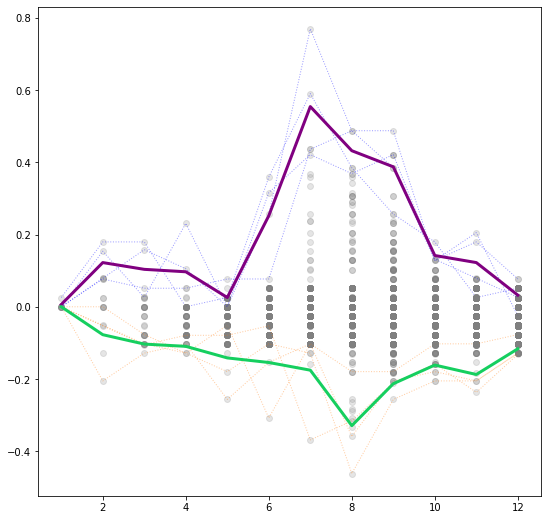

In [40]:
fig = plt.figure(1,figsize=(9,9))
ax1 = fig.add_subplot(111)
anat_avg = np.zeros(12,)
inat_avg = np.zeros(12,)
for f in range(1,5,1):
    clf_result = result[f]
    X = range(1,13,1)
    xticks = []
    x2ticks = []
    anat = []
    inat = []
    for cl in X:
        xticks.append(2**cl)
        x2ticks.append(31410176//2**cl)
        i = 0
        temp = []
        for item in clf_result[cl].keys():
            if cl == 3:
                if clf_result[cl][item][0] in pi_ana[f]:
                    plt.plot(cl,clf_result[cl][item][0],'go',color='#800080')
                elif clf_result[cl][item] in pi_ina[f]:
                    plt.plot(cl,clf_result[cl][item][0],'go',color='#15CF5F')
                else:
                    plt.plot(cl,clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            else:
                plt.plot(cl,clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            temp.append(clf_result[cl][item][0])
            i += 1
        anat.append(np.max(temp))
        inat.append(np.min(temp))
     
    anat_avg = np.add(anat_avg,anat)
    inat_avg = np.add(inat_avg,inat)
    plt.plot(X,anat, color='b',linewidth=1, alpha=0.4,linestyle='dotted')
    plt.plot(X,inat, color='C1',linewidth=1,alpha=0.4,linestyle='dotted')

for i in range(12):
    anat_avg[i] = anat_avg[i] / 4.
    inat_avg[i] = inat_avg[i] / 4.
    
plt.plot(X,anat_avg, color='#800080',linewidth=3,label='Animate')
plt.plot(X,inat_avg, color='#15CF5F',linewidth=3, label ='Inanimate')

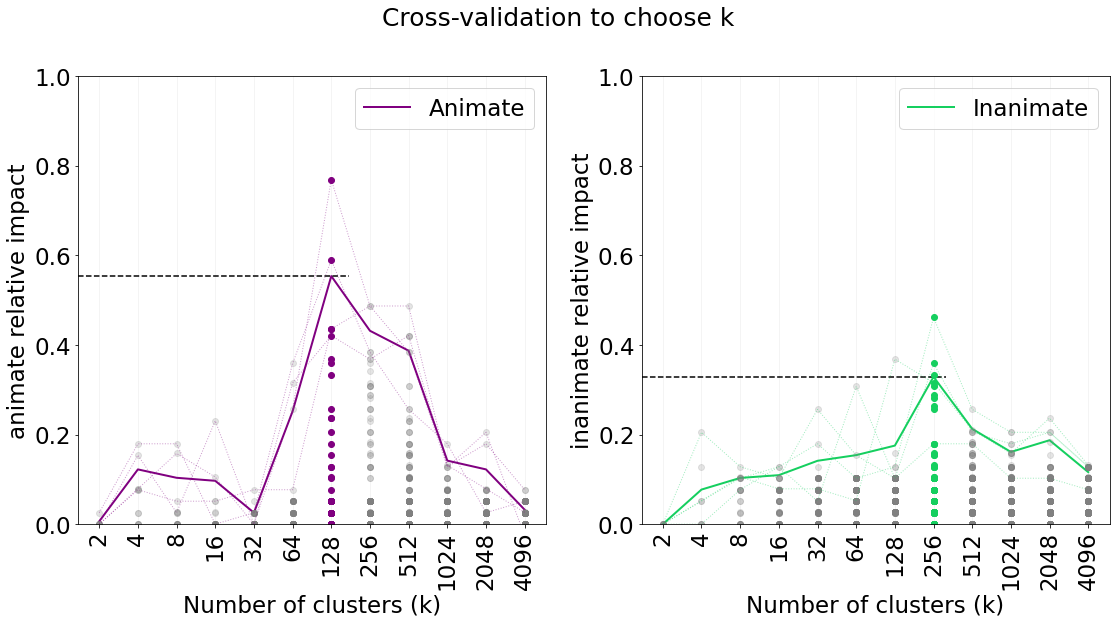

In [43]:
fig, ax = plt.subplots(figsize=(16,9))
matplotlib.rcParams["font.size"] = 23
fig.suptitle('Cross-validation to choose k', fontsize=25)


plt.subplot(1, 2, 1)
plt.plot(range(1,13,1), anat_avg, color='#800080', linewidth=2, label='Animate')
plt.grid(axis='x', color='0.95')
plt.xticks(range(1,13,1),xticks, rotation=90)
plt.axhline(y=max(anat_avg), color='black', linestyle='--', xmin=0, xmax=0.58)
plt.ylim([0,1])
plt.ylabel('animate relative impact')
plt.xlabel('Number of clusters (k)')

for f in range(1,5,1):
    clf_result = result[f]
    X = range(1,13,1)
    anat = []
    for cl in X:
        i = 0
        temp =[]
        for item in clf_result[cl].keys():
            if cl == 7:
                plt.plot(cl,clf_result[cl][item][0],'go',color='#800080')
            else:
                plt.plot(cl,clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            i += 1
            temp.append(clf_result[cl][item][0])
        anat.append(np.max(temp))
    plt.plot(range(1,13,1),anat, color='#800080',linewidth=1, alpha=0.4,linestyle='dotted')
plt.legend()

inat_avg_pos = -1 * inat_avg
plt.subplot(1, 2, 2)
plt.plot(range(1,13,1), inat_avg_pos, color='#15CF5F', linewidth=2, label='Inanimate')
plt.grid(axis='x', color='0.95')
plt.xticks(range(1,13,1),xticks, rotation=90)
plt.axhline(y=max(inat_avg_pos), color='black', linestyle='--', xmin=0, xmax=0.65)
plt.ylabel('inanimate relative impact')
plt.xlabel('Number of clusters (k)')
plt.ylim([0,1])

for f in range(1,5,1):
    clf_result = result[f]
    X = range(1,13,1)
    inat = []
    for cl in X:
        i = 0
        temp =[]
        for item in clf_result[cl].keys():
            if cl == 8:
                plt.plot(cl,-1*clf_result[cl][item][0],'go',color='#15CF5F') 
            else:
                plt.plot(cl,-1*clf_result[cl][item][0],'go',color='grey',alpha=0.2)
            i += 1
            temp.append(-1*clf_result[cl][item][0])
        inat.append(np.max(temp))
    plt.plot(range(1,13,1),inat, color='#15CF5F',linewidth=1, alpha=0.4,linestyle='dotted')
plt.legend()

plt.tight_layout()
plt.savefig('../../../resnet_cross_fold.png')

In [ ]:
import gc
from keras import backend as K 
del model
K.clear_session()
gc.collect()

# Step 2 - Using the k from Step 1 to do the final groupings

In [34]:
folder = 'pkl_resnet'
model_name = 'ResNet101'
debug = False

In [35]:
#%%time
#Testing on test data{
data_path = '../../data/pkl_resnet/'
classes = ['animate','inanimate']

result = {}

with open(data_path+classes[0]+'_test_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_test_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)

X = np.column_stack((X_fold,y_fold))  
if os.path.exists('../../data/pkl_resnet/kmeans_first_test_'+model_name+'.pkl'):
    with open('../../data/pkl_resnet/kmeans_first_test_'+model_name+'.pkl',"rb") as f:
        X_new,pred_kmeans,kmeans = pickle.load(f)
else:   
   
    kmeans = MiniBatchKMeans(n_clusters=62821,
                             random_state=42,
                             batch_size=6,
                             max_iter=10).fit(X)
    #print kmeans.cluster_centers_
    pred_kmeans = kmeans.predict(X)
    X_new = kmeans.cluster_centers_
    with open('../../data/pkl_resnet/kmeans_first_test_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)

#DO CLUSTERING AND GET CLUSTERS

from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
#import genieclust
#import hdbscan
#import smm

j = 128  #Set this value from scree plot!
method = 'GMM'
print(j)
clf = GaussianMixture(n_components=j, covariance_type='full',random_state=42)
temp = clf.fit(X_new)
y_pred = clf.predict(X_new)
print(set(y_pred))


for label in set(y_pred):
    print('Cluster: ',j,'Label: ', label)

    #Lesioning and measuring performance
    pred = y_pred.copy()
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)

    lambda_mask = np.ones(shape=((31410176,)))
    lambda_mask[loc_new] = 0.

    #plt.scatter(X[:,0],X[:,1], c=y_pred) 
    model = ResNet101( include_top=True,
                                    weights="imagenet",
                                    input_tensor=None,
                                    input_shape=None,
                                    pooling=None,
                                    classes=1000,
                                    lambda_mask=lambda_mask)
    flag = 0
    dprime = 0.
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/pkl_resnet/'+p+'_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")

        out = model.predict(im_temp,batch_size=32)
       
        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if flag == 0:
            dprime = error
            flag = 1
        else:
            dprime -= error
    keras.backend.clear_session()
    gc.collect()
    del model

    result[label] = [dprime, loc_new]

128
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}
Cluster:  128 Label:  0
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cluster:  128 Label:  1
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  128 Label:  2
animate 0 39 1.0 0.0
inanimate 0 39 1.0 0.0
Cluster:  128 Label:  3
animate 39 39 0.0 1.0
inanimate 35 39 0.10256410256410253 0.8974358974358975
Cluster:  128 Label:  4
animate 39

Cluster:  128 Label:  65
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  128 Label:  66
animate 39 39 0.0 1.0
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  128 Label:  67
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  128 Label:  68
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  128 Label:  69
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  128 Label:  70
animate 24 39 0.3846153846153846 0.6153846153846154
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  128 Label:  71
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 31 39 0.20512820512820518 0.7948717948717948
Cluster:  128 Label:  72
animate 39 39 0.0 1.0
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cl

In [36]:
list(result.values()),X.shape

([[-0.05128205128205132,
   [414828,
    532623,
    1613963,
    1620043,
    1627537,
    1627787,
    1629451,
    1637329,
    1638492,
    1642507,
    1649483,
    1653323,
    1653955,
    1654595,
    1657799,
    1659531,
    1660124,
    1662147,
    1668363,
    1680779,
    1681667,
    1683210,
    1689978,
    1702219,
    1703043,
    1703493,
    1708569,
    1711420,
    1714711,
    1715658,
    1717337,
    1717724,
    1718295,
    1718332,
    1720139,
    1728011,
    1729034,
    1730827,
    1730947,
    1734617,
    1735132,
    1739717,
    1742155,
    1745820,
    1746251,
    1746972,
    1749404,
    1749468,
    1751769,
    1756555,
    1760395,
    1760715,
    1765529,
    1766219,
    1766908,
    1768587,
    1771979,
    1776139,
    1776395,
    1779915,
    1780747,
    1781660,
    1783004,
    1783577,
    1784220,
    1784331,
    1785308,
    1786588,
    1790236,
    1790411,
    1796363,
    1798876,
    1805067,
    1805852,
    2017367,
  

In [37]:
x = X[:,0]
y = X[:,1]

In [38]:
z_temp = []
for item in y_pred:
    z_temp.append(result[item][0])
print(len(z_temp),len(X_new))
loc_z = kmeans.predict(X_new)
z = np.ones(shape=((31410176,)))
for i in range(len(loc_z)):
    temp = np.where(pred_kmeans==loc_z[i])[0]
    z[temp] = z_temp[i]

62821 62821


In [42]:
loc_ana_avg = []
loc_ina_avg = []

In [44]:
loc_ana_avg = result[ana_128][1]
print(len(loc_ana_avg))

54876


In [49]:
loc_ina_avg = result[ina_256][1]
print(len(loc_ina_avg))

682247


In [50]:
test_loc_ana_avg = loc_ana_avg
test_loc_ina_avg = loc_ina_avg
print(len(test_loc_ana_avg),len(test_loc_ina_avg))

54876 682247


In [40]:
with open('../../data/'+folder+'/kmeans_first_test_128_cluster'+model_name+'.pkl', 'wb') as handle:
        pickle.dump([result,y_pred, z], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [51]:
with open('../../data/'+folder+'/kmeans_first_test_128_cluster'+model_name+'.pkl',"rb") as f:
        result, y_pred_kmeans,z  = pickle.load(f)

In [52]:
print(list(result.values()).index(max(result.values())), list(result.values()).index(min(result.values())))
ana_128 = int(list(result.values()).index(max(result.values())))
ina_128 = int(list(result.values()).index(min(result.values())))
print(result[ana_128][0], -1*(result[ina_128][0]))

122 71
0.35897435897435903 0.17948717948717952


In [47]:
print(list(result.values()).index(max(result.values())), list(result.values()).index(min(result.values())))
ana_256 = int(list(result.values()).index(max(result.values())))
ina_256 = int(list(result.values()).index(min(result.values())))
print(result[ana_256][0], -1*(result[ina_256][0]))

117 137
0.435897435897436 0.5897435897435899


In [53]:
spax = []
spay = []
for i in range(0,len(z)):
    if z[i] == result[ana_128][0]:
        spax.append(x[i])
        spay.append(y[i])
        loc_ana_avg.append(i)

spax = np.asarray(spax)
spay = np.asarray(spay)

In [48]:
spix = []
spiy = []
for i in range(0,len(z)):
    if z[i] == result[ina_256][0]:
        spix.append(x[i])
        spiy.append(y[i])
spix = np.asarray(spix)
spiy = np.asarray(spiy)

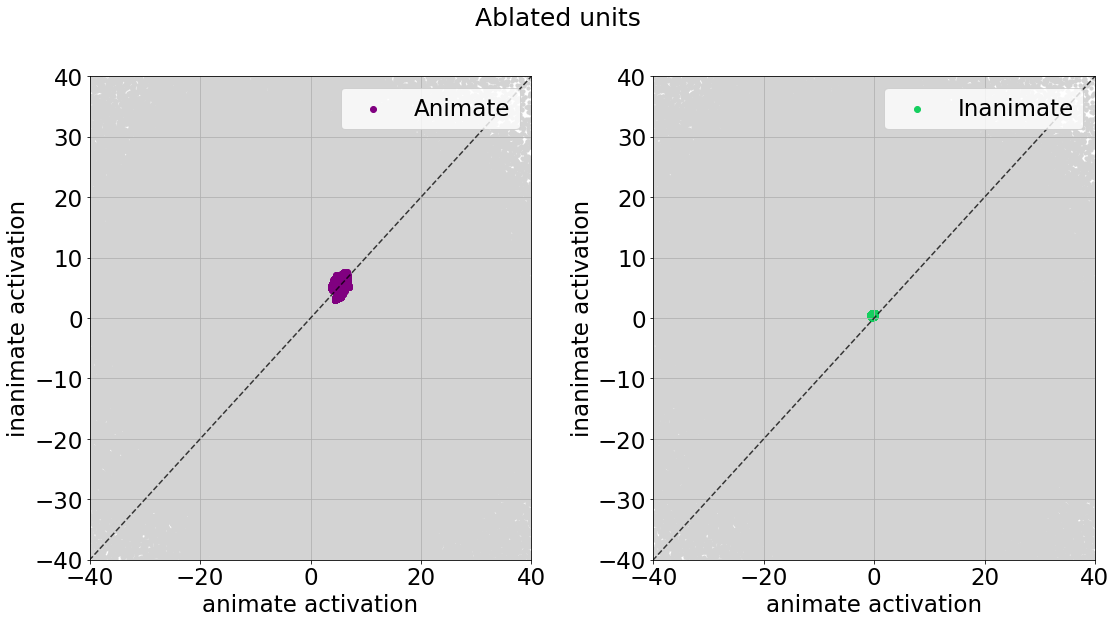

In [57]:
fig, ax = plt.subplots(figsize=(16,9))
matplotlib.rcParams["font.size"] = 23
fig.suptitle('Ablated units', fontsize=25)


plt.subplot(1, 2, 1)
plt.scatter(x,y, c='lightgray', s=10,vmin=-1, vmax=1)
plt.scatter(spax, spay, label='Animate',color='#800080')
plt.plot([-200,200],[-200,200], 'k--', color='black', alpha=0.75)
plt.xlim([-40,40])
plt.ylim([-40,40])
plt.ylabel('inanimate activation')
plt.xlabel('animate activation')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter( x,y, c='lightgray', s=10,vmin=-1, vmax=1)
plt.scatter(spix, spiy, color='#15CF5F', label='Inanimate')
plt.plot([-200,200],[-200,200], 'k--', color='black', alpha=0.75)
plt.xlim([-40,40])
plt.ylim([-40,40])
plt.ylabel('inanimate activation')
plt.xlabel('animate activation')
plt.grid()
plt.legend()

plt.tight_layout()
plt.savefig('../../../resnet_scatter2.png')

In [ ]:
layer_info = {}
#Comparing Layer lesions
classes = ['animate','inanimate']
%time
for label in [ana,ina]:
    layer_info[label] = {}
    for layer in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]:
        if layer == 1:
            start = 0
            end = 3211264
        elif layer == 2:
            start = 3211264
            end = 6422528
        elif layer == 3:
            start = 6422528
            end = 8028160
        elif layer == 4:
            start = 8028160
            end = 9633792
        elif layer == 5:
            start = 9633792
            end = 10436608
        elif layer == 6:
            start = 10436608
            end = 11239424
        elif layer == 7:
            start = 11239424
            end = 12042240
        elif layer == 8:
            start = 12042240
            end = 12443648
        elif layer == 9:
            start = 12443648
            end = 12845056
        elif layer == 10:
            start = 12845056
            end = 13246464
        elif layer == 11:
            start = 13246464
            end = 13346816
        elif layer == 12:
            start = 13346816
            end = 13447168
        elif layer == 13:
            start = 13447168
            end = 13547520
        elif layer == 14:
            start = 13547520
            end = 13551616
        elif layer == 15:
            start = 13551616
            end = 13555712

        layer_info[label][layer] = {}
    
        #No lesion
        #print('No-lesioning')
        #print('Label:',label)
        #print('Layer:',layer)

        pred = clf.predict(X_new)
        lambda_mask = np.ones(shape=((13555712,)))
       

        model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

        flag = 0
        dprime = 0.
        for p in classes:
            im_valid_test = []
            image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
            with open(image_list_valid,'r') as f:
                for line in f.readlines():
                    im_valid_test.append(line.strip('\n'))
            im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            out = model.predict(im_temp,batch_size=64)

            true_valid_wids = []
            for i in im_valid_test:
                    temp1 = i.split('/')[4]
                    temp = temp1.split('.')[0].split('_')[2]
                    true_valid_wids.append(truth[int(temp)][1])

            predicted_valid_wids = []
            for i in range(len(im_valid_test)):
                #print im_list[i], pprint_output(out[i]), true_wids[i]
                predicted_valid_wids.append(pprint_output(out[i]))

            count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

            print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))
              
            if flag == 0:
                dprime = error
                flag = 1
            else:
                dprime -= error
        print('Layer: ',layer,'Label: ', label)
        print('No lesion: ',dprime)
        layer_info[label][layer]['no'] = dprime
        
        tf.keras.backend.clear_session()
        gc.collect()
        del model
        #Before lesion
        #print('Pre-layer-lesioning')
        #print('Label:',label)
        #print('Layer:',layer)

        pred = clf.predict(X_new)
        loc = np.where(pred==label)[0]
        loc_new =[]
        for i in range(len(loc)):
            temp = np.where(pred_kmeans==loc[i])[0]
            loc_new.extend(temp)

        lambda_mask = np.ones(shape=((13555712,)))
        lambda_mask[loc_new] = 0.
        print('pre-loc', len(loc_new))
        model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

        flag = 0
        dprime = 0.
        for p in classes:
            im_valid_test = []
            image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
            with open(image_list_valid,'r') as f:
                for line in f.readlines():
                    im_valid_test.append(line.strip('\n'))
            im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            out = model.predict(im_temp,batch_size=64)

            true_valid_wids = []
            for i in im_valid_test:
                    temp1 = i.split('/')[4]
                    temp = temp1.split('.')[0].split('_')[2]
                    true_valid_wids.append(truth[int(temp)][1])

            predicted_valid_wids = []
            for i in range(len(im_valid_test)):
                #print im_list[i], pprint_output(out[i]), true_wids[i]
                predicted_valid_wids.append(pprint_output(out[i]))

            count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

            print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

            if flag == 0:
                dprime = error
                flag = 1
            else:
                dprime -= error
        print('Cluster Only: ',dprime)
        layer_info[label][layer]['pre'] = dprime   
        tf.keras.backend.clear_session()
        gc.collect()
        del model
             
            
        #After Lesion
       # print('Post-layer-lesioning')
        #print('Label:',label)
        #print('Layer:',layer)
        pred = clf.predict(X_new)
        loc = np.where(pred==label)[0]
        loc_new =[]
        for i in range(len(loc)):
            temp = np.where(pred_kmeans==loc[i])[0]
            temp2 = temp[np.asarray(np.where((temp >end) | (temp <=start))[0])]
            #print(len(temp), len(temp2))
            loc_new.extend(temp2)


        lambda_mask = np.ones(shape=((13555712,)))
        lambda_mask[loc_new] = 0.
        print('post-loc', len(loc_new))
        model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

        flag = 0
        dprime = 0.
        for p in classes:
            im_valid_test = []
            image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
            with open(image_list_valid,'r') as f:
                for line in f.readlines():
                    im_valid_test.append(line.strip('\n'))
            im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            out = model.predict(im_temp,batch_size=64)

            true_valid_wids = []
            for i in im_valid_test:
                    temp1 = i.split('/')[4]
                    temp = temp1.split('.')[0].split('_')[2]
                    true_valid_wids.append(truth[int(temp)][1])

            predicted_valid_wids = []
            for i in range(len(im_valid_test)):
                #print im_list[i], pprint_output(out[i]), true_wids[i]
                predicted_valid_wids.append(pprint_output(out[i]))

            count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

            print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

            if flag == 0:
                dprime = error
                flag = 1
            else:
                dprime -= error
        print('Cluster - layer: ',dprime)
        layer_info[label][layer]['post'] = dprime
        
        
         #Random Lesion
       # print('Post-layer-lesioning')
        #print('Label:',label)
        #print('Layer:',layer)
        pred = clf.predict(X_new)
        loc = np.where(pred==label)[0]
        loc_new =[]
        for i in range(len(loc)):
            temp = np.where(pred_kmeans==loc[i])[0]
            temp2 = temp[np.asarray(np.where((temp >end) | (temp <=start))[0])]
            #print(len(temp), len(temp2))
            loc_new.extend(temp2)

        loc_new2 = np.random.randint(start,end,len(loc_new))
        lambda_mask = np.ones(shape=((13555712,)))
        lambda_mask[loc_new2] = 0.
        print('post-rand-loc', len(loc_new))
        model = VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000,lambda_mask=lambda_mask)

        flag = 0
        dprime = 0.
        for p in classes:
            im_valid_test = []
            image_list_valid = '../../data/pkl/'+p+'_image_list_test.txt'
            with open(image_list_valid,'r') as f:
                for line in f.readlines():
                    im_valid_test.append(line.strip('\n'))
            im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            out = model.predict(im_temp,batch_size=64)

            true_valid_wids = []
            for i in im_valid_test:
                    temp1 = i.split('/')[4]
                    temp = temp1.split('.')[0].split('_')[2]
                    true_valid_wids.append(truth[int(temp)][1])

            predicted_valid_wids = []
            for i in range(len(im_valid_test)):
                #print im_list[i], pprint_output(out[i]), true_wids[i]
                predicted_valid_wids.append(pprint_output(out[i]))

            count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

            print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

            if flag == 0:
                dprime = error
                flag = 1
            else:
                dprime -= error
        print('Random: ',dprime)
        layer_info[label][layer]['rand'] = dprime
        tf.keras.backend.clear_session()
        gc.collect()
        del model
       

In [ ]:
import gc
keras.backend.clear_session()
gc.collect()
if 'model' in locals():
    del model

# Step 3 - Generating Salience figures

In [ ]:
#Pre-trained model - Without lesion
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                    weights="imagenet",input_tensor=None, pooling=None, 
                    classifier_activation="softmax", classes=1000)

In [ ]:
#Pre-trained model - With lesion
'''
label=ana
#print(label,result[label])
pred = clf.predict(X_new)
loc = np.where(pred==label)
loc_temp = kmeans.predict(X_new[loc[0]])
loc_new =[]
for entry in set(loc_temp):
    temp = np.where(pred_kmeans==entry)[0]
    loc_new.extend(temp)
'''
lambda_mask = np.ones(shape=((5725552,)))
print(len(loc_ana_avg),' out of 5725552')
lambda_mask[loc_ana_avg] = 0.
model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                    weights="imagenet",input_tensor=None, pooling=None, 
                    classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)

In [ ]:
image_list_valid = '../../data/pkl_mobile/animate_MobileNetV2_image_list_test.txt'
im_valid_test = []
with open(image_list_valid,'r') as f:
    for line in f.readlines():
        im_valid_test.append(line.strip('\n'))
        
im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
out = model.predict(im_temp,batch_size=64)

true_valid_wids = []
for i in im_valid_test:
        temp1 = i.split('/')[4]
        temp = temp1.split('.')[0].split('_')[2]
        true_valid_wids.append(truth[int(temp)][1])

predicted_valid_wids = []
for i in range(len(im_valid_test)):
    #print im_list[i], pprint_output(out[i]), true_wids[i]
    predicted_valid_wids.append(pprint_output(out[i]))

count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

print(len(true_valid_wids), len(predicted_valid_wids), len(im_valid_test))
print(count, error)
c=0
w=0
flag  = 0
for i in range(len(true_valid_wids)):
    flag  = 0
    temp = true_valid_wids[i]
    for j in predicted_valid_wids[i][0:5]:
        if j == temp:
            flag = 1
            break
    if flag == 1:
        c +=1
        print(i,'1 - Correct')
    else:
        w+=1
        print(i,'0 - Wrong')
print(c,w)

In [ ]:
image_name = im_valid_test[9]
_img = load_img(image_name,target_size=(224,224))
plt.imshow(_img)

In [ ]:
layer_idx = vis_utils.find_layer_idx(model, 'Logits')
model.layers[layer_idx].activation = keras.activations.linear

In [ ]:
# Get model
# Strip softmax layer
#model = innvestigate.utils.model_wo_softmax(model)

# Create analyzer
analyzer = innvestigate.create_analyzer("gradient", model,reverse_keep_tensors=True,allow_lambda_layers =True)

In [ ]:
# Add batch axis and preprocess
image_name = im_valid_test[9]
x = preprocess_image_batch([image_name],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
print(x.shape)
# Apply analyzer w.r.t. maximum activated output-neuron
a = analyzer.analyze(x)

# Aggregate along color channels and normalize to [-1, 1]
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
a /= np.max(np.abs(a))
# Plot
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))
plt.axis('off')

In [ ]:
no_specific_impact_idx = 4
no_impact_idx = 5
animate_impact_idx = 1
inanimate_impact_idx = 2

In [ ]:
import matplotlib.gridspec as gridspec

#fig = plt.figure(figsize=(8, 24),constrained_layout=True) #figsize - width,height
fig = plt.figure(figsize=(16, 8),constrained_layout=True)
fig.set_constrained_layout_pads(w_pad=4/72,h_pad=4/72, hspace=0, wspace=0)
spec = gridspec.GridSpec(ncols=4, nrows=2, figure=fig)
original_flag = 0
row= column = 0
for high_impact_cluster in [-1,1,2]:
    if high_impact_cluster == -1:
        row = 0
        column = 1 
        #Pre-trained model - Without lesion
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                    classifier_activation="softmax", classes=1000)
    elif high_impact_cluster == 1:
        row = 0
        column = 2
        lambda_mask = np.ones(shape=((5725552,)))
        #print(len(loc_new),' out of 5725552')
        lambda_mask[loc_ana_avg] = 0.
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                            classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)
    elif high_impact_cluster == 2:
        row = 0
        column = 3
        lambda_mask = np.ones(shape=((5725552,)))
        #print(len(loc_new),' out of 5725552')
        lambda_mask[loc_ina_avg] = 0.
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                            classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)
    else:
        #Pre-trained model - With lesion
        row =  0
        if high_impact_cluster == 1:
            column = 2
        elif high_impact_cluster == 2:
            column = 3
        elif high_impact_cluster == no_impact_idx:
            column = 2
        elif high_impact_cluster == no_specific_impact_idx:
            column = 3
        elif high_impact_cluster == animate_impact_idx:
            column = 4
        else:
            column = 5
        label=high_impact_cluster
        print(label,result[label])
        pred = clf.predict(X_new)
        loc = np.where(pred==label)
        loc_temp = kmeans.predict(X_new[loc[0]])
        loc_new =[]
        for entry in set(loc_temp):
            temp = np.where(pred_kmeans==entry)[0]
            loc_new.extend(temp)

        lambda_mask = np.ones(shape=((5725552,)))
        #print(len(loc_new),' out of 5725552')
        lambda_mask[loc_new] = 0.
        model = MobileNetV2( input_shape=None, alpha=0.35,include_top=True, 
                            weights="imagenet",input_tensor=None, pooling=None, 
                            classes=1000, classifier_activation="softmax", lambda_mask=lambda_mask)
        
    layer_idx = vis_utils.find_layer_idx(model, 'Logits')
    model.layers[layer_idx].activation = keras.activations.linear
    
    # Create analyzer
    analyzer = innvestigate.create_analyzer("gradient", model,reverse_keep_tensors=True,allow_lambda_layers =True)
    
    for class_label in ['animate','inanimate']:
        image_list_valid = '../../data/pkl_mobile/'+class_label+'_MobileNetV2_image_list_test.txt'
        im_valid_test = []
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))

        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")
        out = model.predict(im_temp,batch_size=64)

        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)
        print(high_impact_cluster, class_label)
        
        color = []
        line_style = []
        c=0
        w=0
        flag  = 0
        for i in range(len(true_valid_wids)):
            flag  = 0
            temp = true_valid_wids[i]
            for j in predicted_valid_wids[i][0:5]:
                if j == temp:
                    flag = 1
                    break
            if flag == 1:
                c +=1
                color.append('green')
                line_style.append('-.')
                #print(i,'1 - Correct')
            else:
                w+=1
                color.append('red')
                line_style.append('-')
                #print(i,'0 - Wrong')
        #print(c,w)
        
        for image_idx in range(23,24): #2,3 - 6,7 - 7,8
            _img = load_img(im_valid_test[image_idx],target_size=(224,224))
            if original_flag < 2:
                ax = fig.add_subplot(spec[row,0])
                ax.imshow(_img)
                ax.axis('off')
                ax.set_aspect('equal')     
                
            x = preprocess_image_batch([im_valid_test[image_idx]],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
            #print(x.shape)
            # Apply analyzer w.r.t. maximum activated output-neuron
            a = analyzer.analyze(x)

            # Aggregate along color channels and normalize to [-1, 1]
            a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
            a /= np.max(np.abs(a))
            # Plot
            #print(row,column)
            ax = fig.add_subplot(spec[row,column])
            ax.imshow(a[0], cmap="seismic", clim=(-1, 1))
            ax.set_xticks([])
            ax.set_yticks([])
            for spine in ax.spines.values():
                spine.set_edgecolor(color[image_idx])
                spine.set_linestyle(line_style[image_idx])
                spine.set_linewidth(4.)
            ax.set_aspect('equal')
            row += 1
            if high_impact_cluster == -1:
                column = 1
            elif high_impact_cluster == 1:
                column = 2
            elif high_impact_cluster == 2:
                column = 3
            elif high_impact_cluster == -1:
                column = 1
            elif high_impact_cluster == no_specific_impact_idx:
                column = 3
            elif high_impact_cluster == animate_impact_idx:
                column = 4
            elif high_impact_cluster == inanimate_impact_idx:
                column = 5
            else:
                column = 1
           
  
        if original_flag < 2:
            original_flag += 1
        '''
        print(len(true_valid_wids), len(predicted_valid_wids), len(im_valid_test))
        print(count, error)
        '''
        
        
    keras.backend.clear_session()
    gc.collect()
    del model
#plt.savefig('../../results/row-6.png', format='png')

# Step 4 - Representation analysis

In [77]:
folder = 'pkl_resnet'
model_name = 'ResNet101'
debug = False

In [78]:
#%%time
#Testing on test data{
data_path = '../../data/pkl_resnet/'
classes = ['animate','inanimate']

result = {}

with open(data_path+classes[0]+'_test_'+model_name+'.pkl','rb') as f:
        X_fold = pickle.load(f)
with open(data_path+classes[1]+'_test_'+model_name+'.pkl','rb') as f:
        y_fold = pickle.load(f)

X = np.column_stack((X_fold,y_fold))  
if os.path.exists('../../data/pkl_resnet/kmeans_first_test_'+model_name+'.pkl'):
    with open('../../data/pkl_resnet/kmeans_first_test_'+model_name+'.pkl',"rb") as f:
        X_new,pred_kmeans,kmeans = pickle.load(f)
else:   
   
    kmeans = MiniBatchKMeans(n_clusters=62821,
                             random_state=42,
                             batch_size=6,
                             max_iter=10).fit(X)
    #print kmeans.cluster_centers_
    pred_kmeans = kmeans.predict(X)
    X_new = kmeans.cluster_centers_
    with open('../../data/pkl_resnet/kmeans_first_test_'+model_name+'.pkl', 'wb') as handle:
        pickle.dump([X_new,pred_kmeans,kmeans], handle, protocol=pickle.HIGHEST_PROTOCOL)


In [79]:
#DO CLUSTERING AND GET CLUSTERS

j = 128  #Set this value from scree plot!
method = 'GMM'
print(j)
clf = GaussianMixture(n_components=j, covariance_type='full',random_state=42)
temp = clf.fit(X_new)
y_pred = clf.predict(X_new)
print(set(y_pred))

128
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127}


In [80]:
#MPPI for each unit calculation
mppi_result = {}
for label in list(set(y_pred)):
    
    #Lesioning and measuring performance
    pred = y_pred.copy()
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)

    lambda_mask = np.ones(shape=((31410176,)))
    lambda_mask[loc_new] = 0.
    
    print('Cluster: ',j,'Label: ', label,'Number of units in cluster:', len(loc_new))
    #plt.scatter(X[:,0],X[:,1], c=y_pred) 
    model = ResNet101( include_top=True,
                                    weights="imagenet",
                                    input_tensor=None,
                                    input_shape=None,
                                    pooling=None,
                                    classes=1000,
                                    lambda_mask=lambda_mask)
    
    flag = 0
    dprime = 0.
    ana_PI, ina_PI= 0, 0
    for p in classes:
        im_valid_test = []
        image_list_valid = '../../data/pkl_resnet/'+p+'_image_list_test.txt'
        with open(image_list_valid,'r') as f:
            for line in f.readlines():
                im_valid_test.append(line.strip('\n'))
        im_temp = preprocess_image_batch(im_valid_test,img_size=(256,256), crop_size=(224,224), color_mode="rgb")

        out = model.predict(im_temp,batch_size=32)
       
        true_valid_wids = []
        for i in im_valid_test:
                temp1 = i.split('/')[4]
                temp = temp1.split('.')[0].split('_')[2]
                true_valid_wids.append(truth[int(temp)][1])

        predicted_valid_wids = []
        for i in range(len(im_valid_test)):
            #print im_list[i], pprint_output(out[i]), true_wids[i]
            predicted_valid_wids.append(pprint_output(out[i]))

        count, error  = top5accuracy(true_valid_wids, predicted_valid_wids)

        print(str(p)+' '+str(count)+' '+str(len(im_valid_test))+' '+str(error)+' '+str(1-error))

        if p == 'animate':
            ana_PI = error
            flag = 1
        else:
            ina_PI = error
    keras.backend.clear_session()
    gc.collect()
    del model
    dprime = ana_PI - ina_PI
    mppi_result[label] = [dprime, ana_PI, ina_PI] 

Cluster:  128 Label:  0 Number of units in cluster: 189858
animate 34 39 0.1282051282051282 0.8717948717948718
inanimate 32 39 0.17948717948717952 0.8205128205128205
Cluster:  128 Label:  1 Number of units in cluster: 3465
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  128 Label:  2 Number of units in cluster: 2661685
animate 0 39 1.0 0.0
inanimate 0 39 1.0 0.0
Cluster:  128 Label:  3 Number of units in cluster: 5993
animate 39 39 0.0 1.0
inanimate 35 39 0.10256410256410253 0.8974358974358975
Cluster:  128 Label:  4 Number of units in cluster: 3746
animate 39 39 0.0 1.0
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  128 Label:  5 Number of units in cluster: 3361
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  128 Label:  6 Number of units in cluster: 8824
animate 39 39 0.0 1.0
inanimate 33 39 0.15384615384615385 0.8461538461538461
C

Cluster:  128 Label:  54 Number of units in cluster: 530
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  128 Label:  55 Number of units in cluster: 2425
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  128 Label:  56 Number of units in cluster: 1179
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  128 Label:  57 Number of units in cluster: 4896
animate 39 39 0.0 1.0
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  128 Label:  58 Number of units in cluster: 3698
animate 39 39 0.0 1.0
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  128 Label:  59 Number of units in cluster: 7561
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  128 Label:  60 Number of units in cluster: 6478
animate 39

Cluster:  128 Label:  107 Number of units in cluster: 2065
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  128 Label:  108 Number of units in cluster: 10166
animate 39 39 0.0 1.0
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  128 Label:  109 Number of units in cluster: 631
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 33 39 0.15384615384615385 0.8461538461538461
Cluster:  128 Label:  110 Number of units in cluster: 2898
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 34 39 0.1282051282051282 0.8717948717948718
Cluster:  128 Label:  111 Number of units in cluster: 5059
animate 38 39 0.02564102564102566 0.9743589743589743
inanimate 35 39 0.10256410256410253 0.8974358974358975
Cluster:  128 Label:  112 Number of units in cluster: 384684
animate 0 39 1.0 0.0
inanimate 0 39 1.0 0.0
Cluster:  128 Label:  113 Number of units in cluster: 9551
animate 39 39 0.0 1.0
inanimate 33 

In [81]:
with open('../../data/'+folder+'/mppi_result_128GMM.pkl', 'wb') as handle:
     pickle.dump([mppi_result], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('../../data/'+folder+'/mppi_result_256GMM.pkl', 'rb') as handle:
     mppi_result = pickle.load(handle)

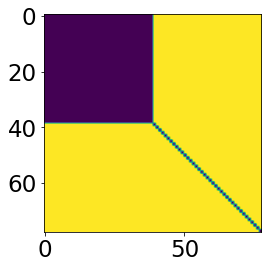

In [63]:
# Create Animate template RDM
animate_template_RDM = np.ones((78,78))
for i in range(39):
    for j in range(39):
        animate_template_RDM[i][j] = 0
for i in range(39,78):
    for j in range(39,78):
        if i == j:
            animate_template_RDM[i][j] = 0
plt.imshow(animate_template_RDM)

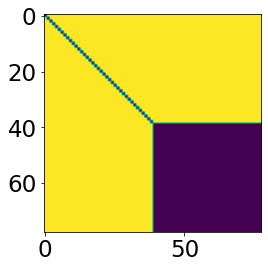

In [64]:
# Create Inanimate template RDM
inanimate_template_RDM = np.ones((78,78))
for i in range(39,78):
    for j in range(39,78):
        inanimate_template_RDM[i][j] = 0
for i in range(39):
    for j in range(39):
        if i == j:
            inanimate_template_RDM[i][j] = 0
plt.imshow(inanimate_template_RDM)

In [66]:
#RDS for each unit calculation
from scipy import stats

#plt.scatter(X[:,0],X[:,1], c=y_pred) 
model = ResNet101( include_top=True,
                    weights="imagenet",
                    input_tensor=None,
                    input_shape=None,
                    pooling=None,
                    classes=1000)
    
dprime = 0.
cluster_activations = {}
cluster_activations['animate'] = np.zeros(shape=(39,31410176))
cluster_activations['inanimate'] = np.zeros(shape=(39,31410176))
for p in classes:

    im_valid_test = []
    image_list_valid = '../../data/pkl_resnet/'+p+'_image_list_test.txt'
    with open(image_list_valid,'r') as f:
        for line in f.readlines():
            im_valid_test.append(line.strip('\n'))

    #Cluster RDM
    flag =0      
    total = 0

    for j in range(len(im_valid_test)):
        im_temp = preprocess_image_batch([im_valid_test[j]],img_size=(256,256), crop_size=(224,224), color_mode="rgb")
        print(p,j,im_valid_test[j])
        data = np.array([])

        i = 0
        for layer in model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:
                activations = get_activations(model,i,im_temp)
                temp = np.mean(activations[0], axis=0).ravel()
                if layer.name != 'probs':
                    #print(layer.name,len(weights),len(activations), activations[0].shape, np.mean(activations[0], axis=0).shape, temp.shape)
                    data = np.append(data, temp)
            i += 1
        cluster_activations[p][j] = data

print(cluster_activations['animate'].shape)

animate 0 ../../data/animate/ILSVRC2012_val_00032025.JPEG
animate 1 ../../data/animate/ILSVRC2012_val_00003604.JPEG
animate 2 ../../data/animate/ILSVRC2012_val_00037913.JPEG
animate 3 ../../data/animate/ILSVRC2012_val_00020432.JPEG
animate 4 ../../data/animate/ILSVRC2012_val_00013504.JPEG
animate 5 ../../data/animate/ILSVRC2012_val_00037239.JPEG
animate 6 ../../data/animate/ILSVRC2012_val_00011596.JPEG
animate 7 ../../data/animate/ILSVRC2012_val_00003116.JPEG
animate 8 ../../data/animate/ILSVRC2012_val_00024410.JPEG
animate 9 ../../data/animate/ILSVRC2012_val_00023958.JPEG
animate 10 ../../data/animate/ILSVRC2012_val_00047167.JPEG
animate 11 ../../data/animate/ILSVRC2012_val_00003822.JPEG
animate 12 ../../data/animate/ILSVRC2012_val_00017384.JPEG
animate 13 ../../data/animate/ILSVRC2012_val_00001490.JPEG
animate 14 ../../data/animate/ILSVRC2012_val_00040504.JPEG
animate 15 ../../data/animate/ILSVRC2012_val_00025566.JPEG
animate 16 ../../data/animate/ILSVRC2012_val_00013828.JPEG
animate

In [67]:
with open('../../data/'+folder+'/cluster_activations.pkl', 'wb') as handle:
     pickle.dump([cluster_activations], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [82]:
with open('../../data/'+folder+'/cluster_activations.pkl', 'rb') as handle:
     cluster_activations = pickle.load(handle)

In [83]:
#rds for each unit calculation
model = ResNet101( include_top=True,
                    weights="imagenet",
                    input_tensor=None,
                    input_shape=None,
                    pooling=None,
                    classes=1000)
rds_result = {}
for label in list(set(y_pred)):
    
    #Lesioning and measuring performance
    pred = y_pred.copy()
    loc = np.where(pred==label)
    loc_temp = kmeans.predict(X_new[loc[0]])
    loc_new =[]
    for entry in set(loc_temp):
        temp = np.where(pred_kmeans==entry)[0]
        loc_new.extend(temp)
  
    print('Label: ', label, len(loc_new))
    dprime = 0.
    act = np.vstack((cluster_activations[0][classes[0]][:,loc_new],cluster_activations[0][classes[1]][:,loc_new]))
    cluster_RDM = 1 - np.corrcoef(act)    
    ana_RDS, _ = stats.kendalltau(cluster_RDM,animate_template_RDM)
    ina_RDS, _ = stats.kendalltau(cluster_RDM,inanimate_template_RDM)
    dprime = ana_RDS - ina_RDS
    
    rds_result[label] = [dprime, ana_RDS, ina_RDS]

keras.backend.clear_session()
gc.collect()
del model

Label:  0 189858
Label:  1 3465
Label:  2 2661685
Label:  3 5993
Label:  4 3746
Label:  5 3361
Label:  6 8824
Label:  7 90840
Label:  8 1497
Label:  9 700
Label:  10 10735
Label:  11 364
Label:  12 7236
Label:  13 1269
Label:  14 5982
Label:  15 16059
Label:  16 2217
Label:  17 928683
Label:  18 3197
Label:  19 2617
Label:  20 22719
Label:  21 11035
Label:  22 2180
Label:  23 687
Label:  24 14673964
Label:  25 619
Label:  26 1529
Label:  27 8462
Label:  28 1210
Label:  29 18828
Label:  30 1548
Label:  31 487
Label:  32 3624
Label:  33 6518
Label:  34 1175
Label:  35 472
Label:  36 95
Label:  37 5574
Label:  38 3175
Label:  39 4848
Label:  40 268
Label:  41 21325
Label:  42 6186
Label:  43 1436
Label:  44 3562
Label:  45 19948
Label:  46 5106
Label:  47 1048
Label:  48 1485149
Label:  49 3417
Label:  50 67258
Label:  51 275
Label:  52 2625
Label:  53 10557
Label:  54 530
Label:  55 2425
Label:  56 1179
Label:  57 4896
Label:  58 3698
Label:  59 7561
Label:  60 6478
Label:  61 4560
Label

In [85]:
with open('../../data/'+folder+'/rds_result_128GMM.pkl', 'wb') as handle:
     pickle.dump([rds_result], handle, protocol=pickle.HIGHEST_PROTOCOL)

256 256 0.435897435897436 -0.5897435897435899 0.05258001018234354 -0.024330587258195292


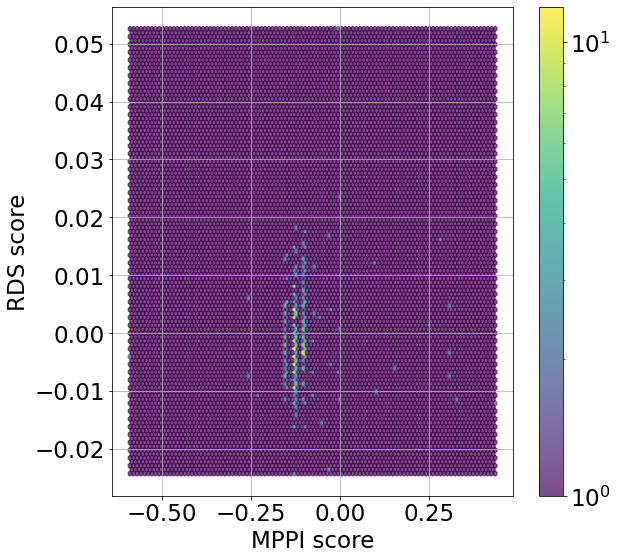

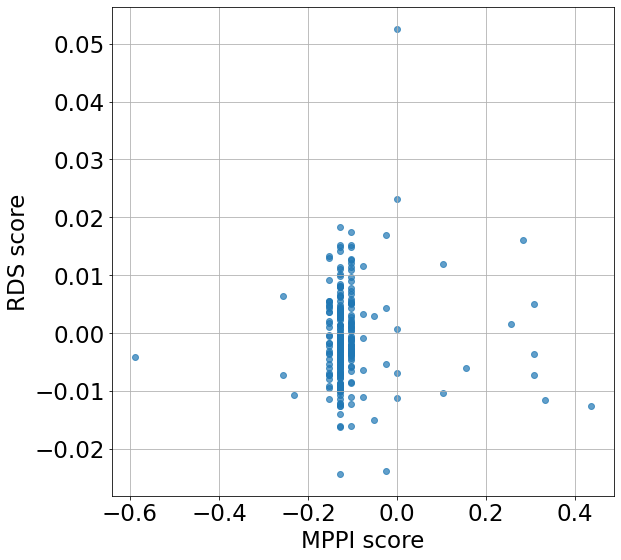

In [90]:
# with open('../../data/'+folder+'/mppi_result_256GMM.pkl', 'rb') as handle:
#      mppi_result = pickle.load(handle)

# with open('../../data/'+folder+'/rds_result_256GMM.pkl', 'rb') as handle:
#      rds_result = pickle.load(handle)

with open('../../../mppi_result_50k.pkl', 'rb') as handle:
     mppi_result = pickle.load(handle)

with open('../../data/M.pkl', 'rb') as handle:
     rds_result = pickle.load(handle)

x = np.array([i[0] for i in list(mppi_result[0].values())])
y = np.array([i[0] for i in list(rds_result[0].values())])
print(len(x), len(y), max(x), min(x), max(y), min(y))

plt.figure(figsize=(9,9))
plt.hexbin(x,y,alpha=0.7, bins='log')
plt.xlabel('MPPI score')
plt.ylabel('RDS score')
plt.grid()
plt.colorbar()
#plt.xlim([-0.2,0.2])
#plt.ylim([-0.35,0.2])

plt.figure(figsize=(9,9))
plt.scatter(x,y,alpha=0.7)
plt.xlabel('MPPI score')
plt.ylabel('RDS score')
plt.grid()

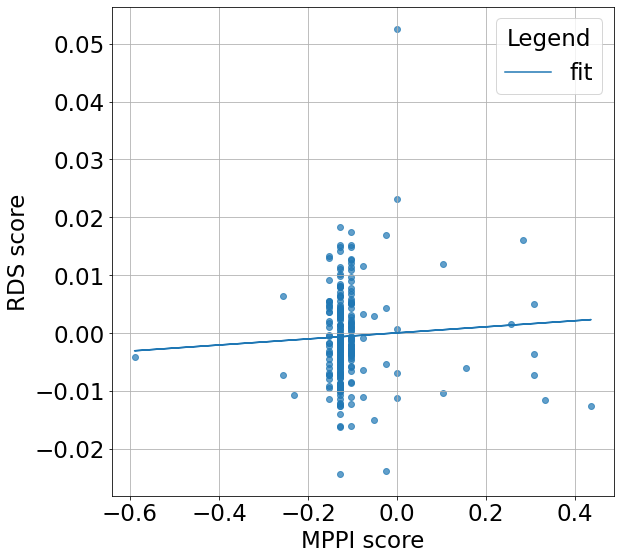

In [91]:
import scipy
def line(x, a):
    """The line of best fit."""
    # unpack the parameters:
    y = a*x
    return y

popt, pcov = scipy.optimize.curve_fit(line, x, y)

# unpack the parameters of the line of best fit:
a = popt

plt.figure(figsize=(9,9))
plt.scatter(x,y,alpha=0.7)
plt.xlabel('MPPI score')
plt.ylabel('RDS score')
plt.grid()
plt.plot(x, line(x, a), label='fit')
plt.legend(title='Legend')

In [92]:
import scipy.odr as odr
def odr_line(p, x):
    """The line of best fit."""
    # unpack the parameters:
    y = p*x
    return y

def perform_odr(x, y):
    """Finds the ODR for data {x, y} and returns the result"""
    linear = odr.Model(odr_line)
    mydata = odr.Data(x, y,we=1/np.var(x), wd=1/np.var(y))
    myodr = odr.ODR(mydata, linear, beta0=[0])
    output = myodr.run()
    return output
regression = perform_odr(x, y)

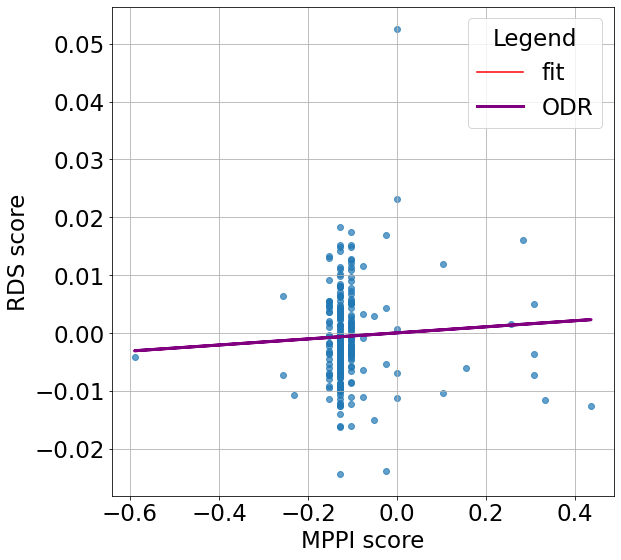

In [93]:
plt.figure(figsize=(9,9))
plt.scatter(x,y,alpha=0.7)
plt.xlabel('MPPI score')
plt.ylabel('RDS score')
plt.grid()
plt.plot(x, line(x, a), label='fit',color='red')
plt.plot(x, line(x, regression.beta[0]), label='ODR', lw=3, color='purple')
plt.legend(title='Legend')